In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="ticks", rc={'figure.figsize':(9,8)})
sns.set_context(rc = {"font.size":15, "axes.labelsize":15}, font_scale=2)
sns.set_palette('colorblind');
from pandas.api.types import CategoricalDtype

from scipy import stats

from scipy.stats import pearsonr,spearmanr, boxcox_normmax, chi2_contingency, chi2, f, shapiro, probplot
from scipy.special import boxcox1p

import statsmodels.api as sm
from statsmodels.formula.api import ols 

# pandas defaults
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

import warnings
warnings.filterwarnings('ignore')

from time import time

## Loading Dataset

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Training data shape: ", train.shape)
print("Testing data shape: ", test.shape)

Training data shape:  (1460, 81)
Testing data shape:  (1459, 80)


## Removing outliers

In [3]:
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace = True)
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace = True)
train.reset_index(drop=True, inplace=True)
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.shape

(1457, 81)

In [5]:
sale_price_df = train[['SalePrice']].copy()

### rbinding train and test data

In [6]:
data = pd.concat([train.drop(columns='SalePrice'), test], axis = 0)
data.shape

(2916, 80)

### checking for presence of null

In [7]:
round((data.isnull().sum()[data.isnull().sum()!=0]/data.shape[0])*100,2)

MSZoning         0.14
LotFrontage     16.63
Alley           93.21
Utilities        0.07
Exterior1st      0.03
Exterior2nd      0.03
MasVnrType       0.82
MasVnrArea       0.79
BsmtQual         2.78
BsmtCond         2.81
BsmtExposure     2.81
BsmtFinType1     2.71
BsmtFinSF1       0.03
BsmtFinType2     2.74
BsmtFinSF2       0.03
BsmtUnfSF        0.03
TotalBsmtSF      0.03
Electrical       0.03
BsmtFullBath     0.07
BsmtHalfBath     0.07
KitchenQual      0.03
Functional       0.07
FireplaceQu     48.70
GarageType       5.38
GarageYrBlt      5.45
GarageFinish     5.45
GarageCars       0.03
GarageArea       0.03
GarageQual       5.45
GarageCond       5.45
PoolQC          99.69
Fence           80.42
MiscFeature     96.40
SaleType         0.03
dtype: float64

### Dropping ID column

In [8]:
data.drop(columns = 'Id', inplace = True)

> Eliminating features with low variance and zero variance. Zero variance features are comprised of the same values. Low variance features arise from features with most values the same and with few unique values. One way low variance features can arise, is from dummy variables for categories with very few members. The dummy variable will be mostly 0s with very few 1s.

First thing to do is get rid of the features with more than 80% missing values (figure below). For example the PoolQC's missing values are probably due to the lack of pools in some buildings, which is very logical. But replacing those (more than 80%) missing values with "no pool" will leave us with a feature with low variance, and low variance features are not informative for machine learning models. So we drop the features with more than 80% missing values or 80% same object/category value.

### Dropping columns

1. MAsVnrArea, BsmtFinSF1, BsmtFinSF2,
2ndFlrSF, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, PoolArea, MiscVal

 to categorical column using bins


Columns to be dropped because of very low varaiance:


In [9]:
data.drop(columns = ['LowQualFinSF',  'BsmtHalfBath', 'ScreenPorch',  'Street', 'Alley', 'Utilities', 'LandSlope', 
                     'Condition1', 'Condition2', 'BldgType', 'RoofMatl', 'ExterCond', 'BsmtCond',  'BsmtFinType2', 
                     'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 
                     'PoolQC', 'Fence', 'MiscFeature', 'SaleType'], inplace = True) 

In [10]:
data.shape

(2916, 54)

In [11]:
data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'Neighborhood', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'Foundation',
       'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
       'SaleCondition'],
      dtype='object')

Filling NA values of numerical columns

In [12]:
for col in ['BsmtFullBath']:
    data[col] = data[col].fillna(data[col].value_counts().idxmax())
    
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(0)
    
for col in ['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF','GarageCars','GarageArea', 'MasVnrArea', 'LotFrontage']:
    data[col] = data[col].fillna(data[col].median())

Filling NA values of object/categorical columns

In [13]:
for col in ['MasVnrType']:
    data[col] = data[col].fillna(data[col].value_counts().idxmax())
    
for col in ['GarageType', 'GarageFinish', 'BsmtQual', 'BsmtExposure',  'BsmtFinType1', 'FireplaceQu']:
    data[col] = data[col].fillna('None')
    
data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].value_counts().index[0])
# data['Utilities'] = data['Utilities'].fillna(data['Utilities'].value_counts().index[0])
# data['GarageCond'] = data['GarageCond'].fillna('None')
# data['SaleType'] = data['SaleType'].fillna(data['SaleType'].value_counts().index[0])
# data['Functional'] = data['Functional'].fillna(data['Functional'].value_counts().index[0])
data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].value_counts().index[0])
data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].value_counts().index[0])
data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].value_counts().index[0])

In [14]:
data.isnull().sum()[data.isnull().sum()!=0]

Series([], dtype: int64)

So NA values of all columns are filled.

### Creating new features

In [15]:
data['House_Qual'] = data['OverallQual'] + data['OverallCond']
data['Total_bathrooms'] = data['BsmtFullBath'] + data['FullBath'] + data['HalfBath']
data['Total_basement_SF'] = data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['TotalBsmtSF']
data['Total_sqr_footage'] = data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['1stFlrSF'] + data['2ndFlrSF']

#### Some of the non-numeric predictors are stored as numbers; convert them into strings 

In [16]:
data['MSSubClass'] = data['MSSubClass'].astype(str)
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)

In [17]:
data.drop(columns = ['MiscVal', 'PoolArea', '3SsnPorch', 'EnclosedPorch', 'BsmtFinSF2'], inplace = True)

In [18]:
data.drop(columns = 'KitchenQual', inplace = True)

### Converting some continuous variable to categorical variable

In [19]:
# data['OpenPorchSF'] = pd.cut(data['OpenPorchSF'], bins = np.arange(-1, 750, 50))
# data['WoodDeckSF'] = pd.cut(data['WoodDeckSF'], bins = np.arange(0, 1500, 100))
# data['BsmtFinSF1'] = pd.cut(data['BsmtFinSF1'], bins = np.arange(-1, 4200, 100))
# data['2ndFlrSF'] = pd.cut(data['2ndFlrSF'], bins = np.arange(-1, 2200, 100))

### Dealing with all object/category type columns
Converting object columns to ordinal category type

In [20]:
cat_type = CategoricalDtype(['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
for col in ['BsmtQual', 'FireplaceQu']:
    data[col] = data[col].astype(cat_type)
    
cat_type = CategoricalDtype(['IR3', 'IR2', 'IR1', 'Reg'], ordered=True)
data['LotShape'] = data['LotShape'].astype(cat_type)

cat_type = CategoricalDtype(['None', 'No', 'Mn', 'Av', 'Gd'], ordered=True)
data['BsmtExposure'] = data['BsmtExposure'].astype(cat_type)

cat_type = CategoricalDtype(['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], ordered=True)
for col in ['BsmtFinType1']:
    data[col] = data[col].astype(cat_type)

In [21]:
cat_type = CategoricalDtype(['Low', 'HLS', 'Bnk', 'Lvl'], ordered=True)
data['LandContour'] = data['LandContour'].astype(cat_type)

cat_type = CategoricalDtype(['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
for col in ['ExterQual']:
    data[col] = data[col].astype(cat_type)
    
cat_type = CategoricalDtype(['None', 'Detchd', 'CarPort', 'BuiltIn', 'Basment', 'Attchd', '2Types'],ordered=True)
data['GarageType'] = data['GarageType'].astype(cat_type)

cat_type = CategoricalDtype(['None', 'Unf', 'RFn', 'Fin'],ordered=True)
data['GarageFinish'] = data['GarageFinish'].astype(cat_type)


### Create new features

In [22]:
data['Has_Garage'] = np.where(data['GarageArea']>0,1,0)
data['Has_basement'] = np.where(data['Total_basement_SF'] > 0, 1, 0)
data['Has_fireplace'] = np.where(data['Fireplaces']>0,1,0)

In [23]:
for col in data.filter(regex = '^Has', axis = 'columns').columns:
    print(data[col].value_counts(normalize = True))

1    0.946159
0    0.053841
Name: Has_Garage, dtype: float64
1    0.973251
0    0.026749
Name: Has_basement, dtype: float64
1    0.513032
0    0.486968
Name: Has_fireplace, dtype: float64


Majority of the columns starting with __Has__ has a low variance so dropping those columns.

In [24]:
data.drop(columns = ['Has_Garage', 'Has_basement'], inplace = True)

In [25]:
data.shape

(2916, 53)

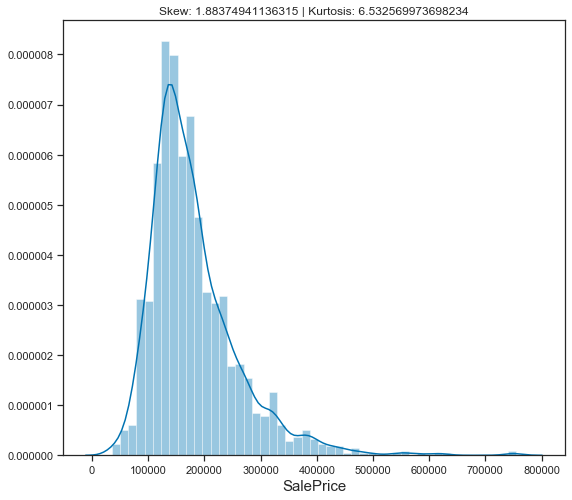

In [26]:
sns.distplot(sale_price_df['SalePrice']);
plt.title("Skew: {} | Kurtosis: {}".format(sale_price_df['SalePrice'].skew(), sale_price_df['SalePrice'].kurt()));

In [27]:
numeric_columns = data.select_dtypes('number').columns
numeric_columns = numeric_columns[~numeric_columns.str.contains('^Has')]
numeric_columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'House_Qual', 'Total_bathrooms', 'Total_basement_SF',
       'Total_sqr_footage'],
      dtype='object')

In [28]:
len(numeric_columns)

29

In [29]:
X_train = data.iloc[:len(train),:].copy()
X_test = data.iloc[len(train):,:].copy()
X_train = pd.concat([X_train,sale_price_df['SalePrice']], axis = 1)

In [30]:
X_train.dtypes

MSSubClass             object
MSZoning               object
LotFrontage           float64
LotArea                 int64
LotShape             category
LandContour          category
LotConfig              object
Neighborhood           object
HouseStyle             object
OverallQual             int64
OverallCond             int64
YearBuilt               int64
YearRemodAdd            int64
RoofStyle              object
Exterior1st            object
Exterior2nd            object
MasVnrType             object
MasVnrArea            float64
ExterQual            category
Foundation             object
BsmtQual             category
BsmtExposure         category
BsmtFinType1         category
BsmtFinSF1            float64
BsmtUnfSF             float64
TotalBsmtSF           float64
HeatingQC              object
1stFlrSF                int64
2ndFlrSF                int64
GrLivArea               int64
BsmtFullBath          float64
FullBath                int64
HalfBath                int64
BedroomAbv

### Use heatmap to check for multicorrelation

In [31]:
def generate_heatmap(df):
    # Generate a heatmap with the upper triangular matrix masked
    # Compute the correlation matrix
    corr = df.corr(method="spearman")
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    plt.figure(figsize = (15,9));
    # Draw the heatmap with the mask 
    sns.heatmap(corr, mask=mask, cmap='coolwarm', fmt = '.2f', linewidths=.5, annot = True);
    plt.title("Correlation heatmap");
    return

### Check correlation of predictor variables with target variables

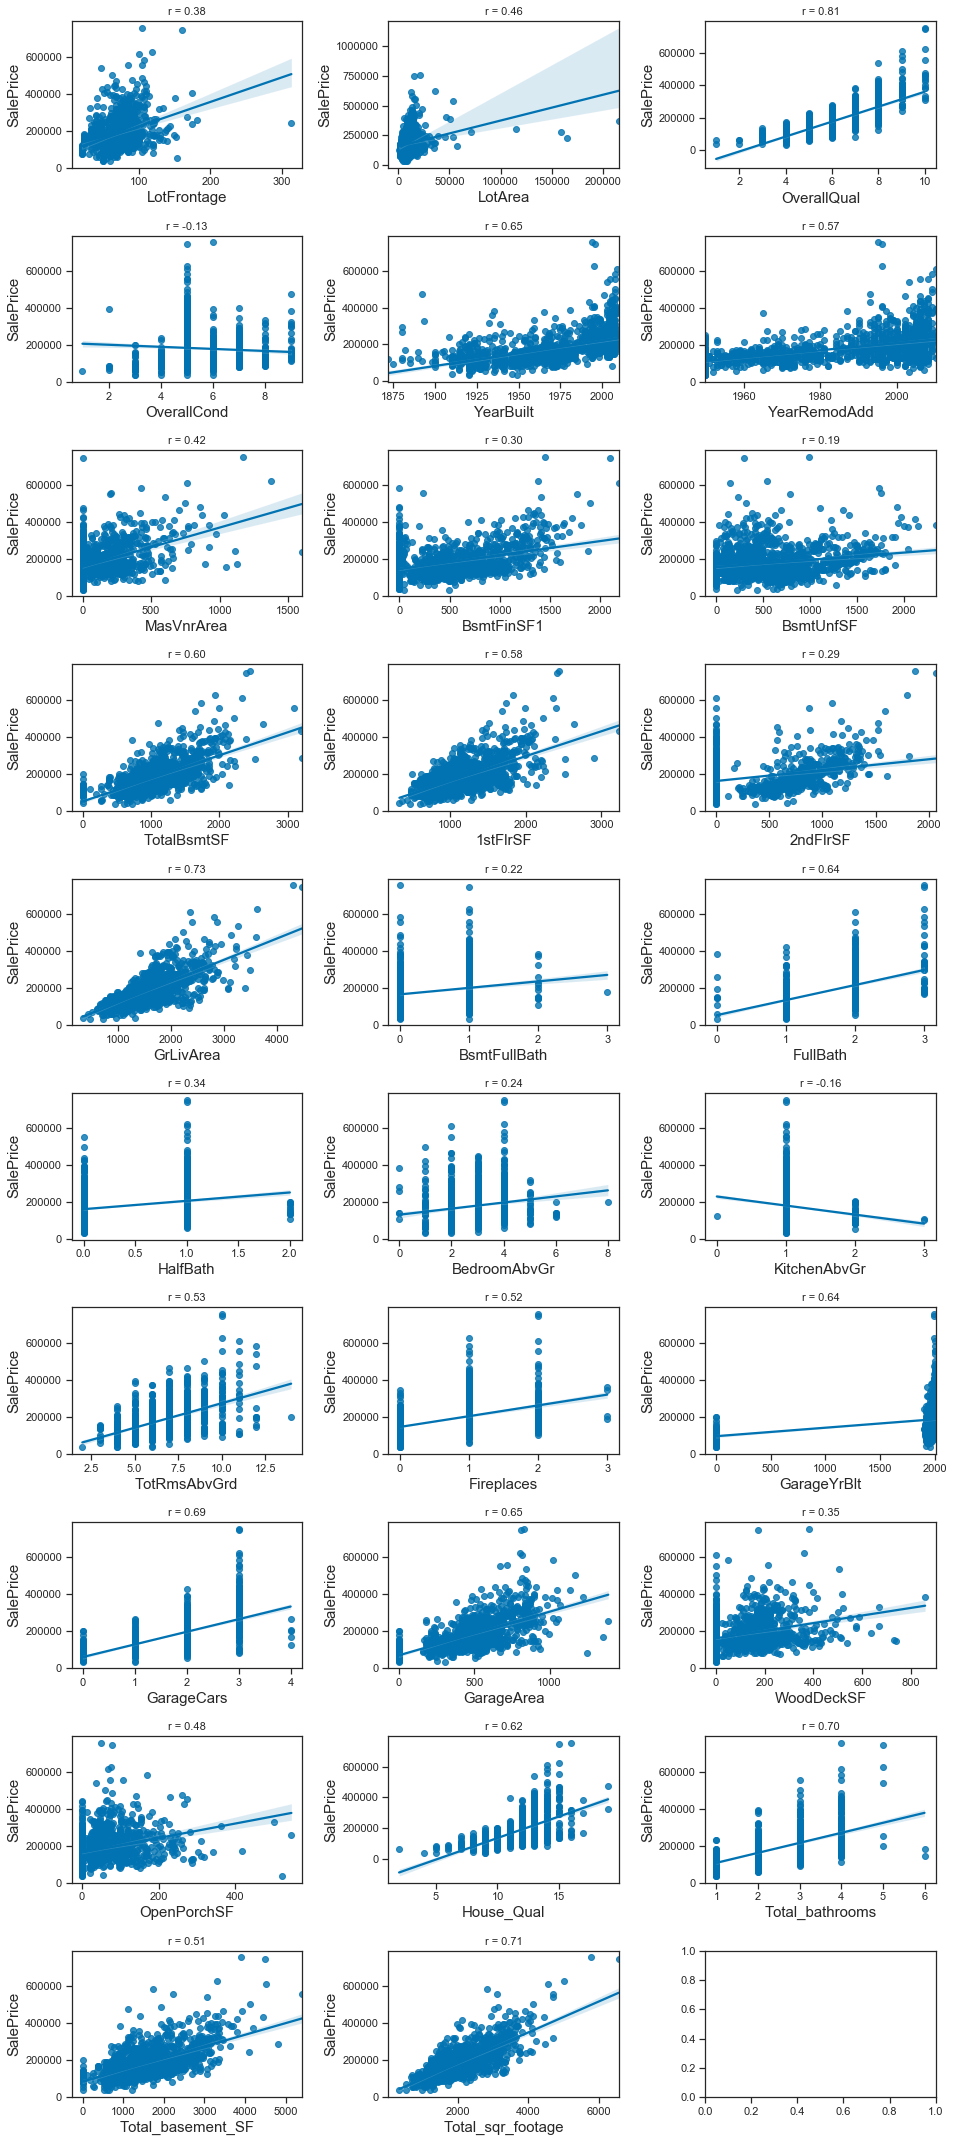

In [32]:
import math
correlation_results_list = []
ncols = 3
nrows = math.ceil(len(numeric_columns)/ncols)
fig, axes = plt.subplots(nrows,ncols, figsize=(ncols*4.5,nrows*3))
axes_list = [item for sublist in axes for item in sublist] 
for col in numeric_columns:
    ax = axes_list.pop(0) # Take the first axes of the axes_list
    sns.regplot(X_train[col], X_train['SalePrice'], ax = ax)
    stp = spearmanr(X_train[col], X_train['SalePrice'])
    str_title = "r = " + "{0:.2f}".format(stp[0])
    ax.set_title(str_title,fontsize=11)
    correlation_results_list.append((col, abs(stp[0])))
    
plt.tight_layout(); 
plt.show();

In [33]:
correlation_df = pd.DataFrame(correlation_results_list, columns = ['column_name', 'correlation'])
correlation_df.sort_values(by = 'correlation', ascending = False, inplace = True)
correlation_df.head()

,column_name,correlation
2,OverallQual,0.813513
12,GrLivArea,0.732349
28,Total_sqr_footage,0.707817
26,Total_bathrooms,0.697553
21,GarageCars,0.691027


In [34]:
columns_with_high_corr = correlation_df.loc[correlation_df['correlation']>=0.6, 'column_name'].to_list()
columns_with_high_corr

['OverallQual',
 'GrLivArea',
 'Total_sqr_footage',
 'Total_bathrooms',
 'GarageCars',
 'YearBuilt',
 'GarageArea',
 'FullBath',
 'GarageYrBlt',
 'House_Qual',
 'TotalBsmtSF']

Dropping numeric columns having low correlation

In [35]:
columns_with_low_corr = correlation_df[correlation_df['correlation']<0.6]['column_name'].to_list()

### Dropping columns having low correlation with SalePrice

In [36]:
data.drop(columns = columns_with_low_corr, inplace = True)
X_train.drop(columns = columns_with_low_corr, inplace = True)

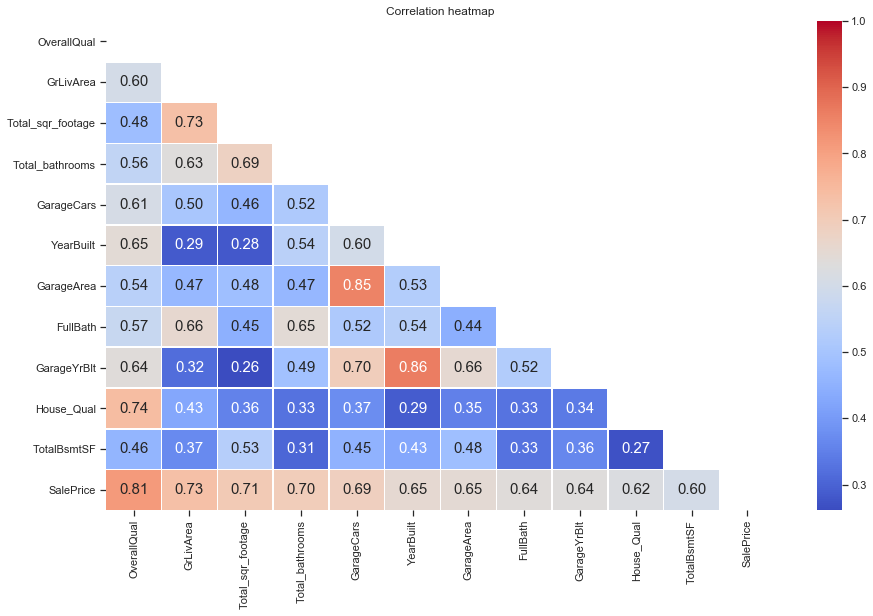

In [37]:
generate_heatmap(X_train[columns_with_high_corr+['SalePrice']])

Dropping columns to avoid multicolinearity
- OverallQual with __House_Qual__ 
- YearBuilt with __GarageYrBlt__
- GrLivArea with __Total_sqr_footage__ 
- GarageCars with __GarageArea__

- GarageCars with __GarageArea and GarageYrBlt__

### Dropping columns to avoid multicolinearity

In [38]:
data.drop(columns = ['House_Qual', 'GarageArea', 'GarageYrBlt', 'Total_sqr_footage', 'YearBuilt'], inplace = True)
X_train.drop(columns = ['House_Qual', 'GarageArea', 'GarageYrBlt', 'Total_sqr_footage', 'YearBuilt'], inplace = True)

In [39]:
data.shape

(2916, 30)

In [40]:
X_train.shape

(1457, 31)

In [41]:
category_cols = X_train.select_dtypes(['object', 'category', 'int32']).columns
category_cols

Index(['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig',
       'Neighborhood', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure',
       'BsmtFinType1', 'HeatingQC', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'MoSold', 'YrSold', 'SaleCondition', 'Has_fireplace'],
      dtype='object')

#### Applying log(1+x) transform on SalePrice

For performing anova the numerical variable must be normally distributed

In [42]:
X_train['SalePrice'] = np.log1p(X_train['SalePrice'])

### Nominal Categorical and continuous (target) variable

In [43]:
categ_columns_with_high_association = []
categ_columns_with_low_association = []
def perform_anova_and_its_results(categ_col, num_col='SalePrice', df = X_train):
    df_sst = len(df[num_col])-1
    df_ssb = df[categ_col].nunique() - 1
    df_ssw = df_sst - df_ssb
    F_critical = f.ppf(0.95, df_ssb, df_ssw)
#     print("F_Critical: {0:.3f}".format(F_critical))
    results = ols('{} ~{}'.format(num_col, categ_col), data = df).fit()
    aov_table = sm.stats.anova_lm(results, typ = 1)  
    F_stat = aov_table.loc[categ_col, 'F']
#     print("F_statistic: {0:.3f}".format(F_stat))
    if (F_stat > F_critical):
#         print("F-statistic is more than F-critical")
#         print("There is an association between {} and {}".format(categ_col,num_col))
        categ_columns_with_high_association.append(categ_col)
    else:
#         print("F-statistic is less than F-critical")
#         print("There is no association between {} and {}".format(categ_col,num_col))
        categ_columns_with_low_association.append(categ_col)
#     print('-'*30)

In [44]:
for col in category_cols:
    perform_anova_and_its_results(col)

In [45]:
categ_columns_with_low_association

['MoSold', 'YrSold']

#### Dropping columns

In [46]:
data.drop(columns = categ_columns_with_low_association, inplace = True)
X_train.drop(columns = categ_columns_with_low_association, inplace = True)

#### Association between 2 nominal binary variables
Can be used to avoid multicolinearity

In [47]:
def phi_coefficient(a,b):
    temp = pd.crosstab(a,b)
    nr = (temp.iloc[1,1] * temp.iloc[0,0]) - (temp.iloc[0,1]*temp.iloc[1,0])
    dr = np.sqrt(np.product(temp.apply(sum, axis = 'index')) * np.prod(temp.apply(sum, axis = 'columns')))
    return(nr/dr)

In [48]:
cat_binary_cols = []
for col in X_train.select_dtypes(['int32', 'object']).columns:
    if (X_train[col].nunique()==2):
        cat_binary_cols.append(col)
        
cat_binary_cols

['Has_fireplace']

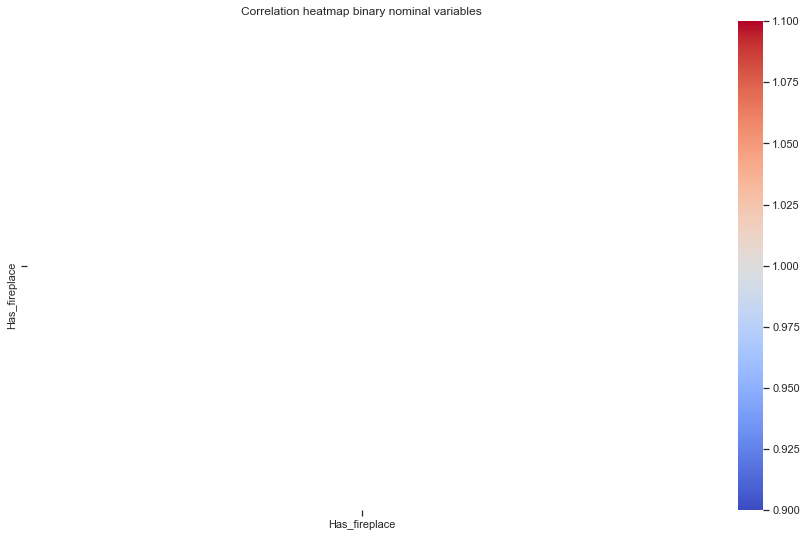

In [49]:
temp = pd.DataFrame(columns=cat_binary_cols, index=cat_binary_cols).fillna(0)
for row in cat_binary_cols:
    a = row
    for col in cat_binary_cols:
        b = col
        temp.loc[a,b] = phi_coefficient(X_train[a],X_train[b])
        temp.loc[b,a] = temp.loc[a,b]
          
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(temp, dtype=np.bool))
plt.figure(figsize = (15,9));
# Draw the heatmap with the mask 
sns.heatmap(temp, mask=mask, cmap='coolwarm', fmt = '.2f', linewidths=.5, annot = True);
plt.title("Correlation heatmap binary nominal variables");

There is no association or correlation between the nominal and binary variables.

In [50]:
del(cat_binary_cols)

#### EDA - Category and Category analysis



In [51]:
def cramers_v(a,b):
    crosstab = pd.crosstab(a,b)
    chi2 = chi2_contingency(crosstab)[0]  # chi-squared value
    n = crosstab.sum().sum()
    phi2 = chi2/n
    r, k = crosstab.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return(np.sqrt(phi2corr/min((kcorr-1),(rcorr-1))))


from collections import Counter
def conditional_entropy(x, y):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    :param x: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :param y: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :return: float
    """
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy


def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = stats.entropy(p_x)
    if s_x == 0:
        return(1)
    else:
        return((s_x - s_xy)/s_x)

In [52]:
category_cols = X_train.select_dtypes(['object', 'category', 'int32']).columns.to_list()
category_cols

['MSSubClass',
 'MSZoning',
 'LotShape',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'HouseStyle',
 'RoofStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'Foundation',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'HeatingQC',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'SaleCondition',
 'Has_fireplace']

In [53]:
len(category_cols)

22

In [54]:
temp = pd.DataFrame(columns=category_cols, index=category_cols).fillna(0)
cat_col_correlation = []
for row in category_cols:
    a = row
    for col in category_cols:
        b = col
        temp.loc[a,b] = theils_u(X_train[a],X_train[b])
        temp.loc[b,a] = temp.loc[a,b]
        cat_col_correlation.append((a,b,temp.loc[a,b]))
          
# Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(temp, dtype=np.bool))
# plt.figure(figsize = (24,15));
# # Draw the heatmap with the mask 
# sns.heatmap(temp, cmap='coolwarm', mask = mask, linewidths=.005, cbar=False);
# plt.title("Correlation heatmap categorical variables");

In [55]:
cat_cols_corr_df = pd.DataFrame(cat_col_correlation, columns = ['col1', 'col2', 'correlation'])
cat_cols_corr_df.head()

,col1,col2,correlation
0,MSSubClass,MSSubClass,1.000000
1,MSSubClass,MSZoning,0.109543
2,MSSubClass,LotShape,0.030206
3,MSSubClass,LandContour,0.020963
4,MSSubClass,LotConfig,0.017846


In [56]:
cat_cols_corr_df.shape

(484, 3)

In [57]:
high_corr_cat=cat_cols_corr_df[(cat_cols_corr_df['correlation']>=0.6) & (cat_cols_corr_df['col1']!=cat_cols_corr_df['col2'])]
high_corr_cat.head()

,col1,col2,correlation
27,MSZoning,Neighborhood,0.672667
132,HouseStyle,MSSubClass,0.900760
185,Exterior1st,Exterior2nd,0.824017
206,Exterior2nd,Exterior1st,0.797999
479,Has_fireplace,FireplaceQu,1.000000


In [58]:
high_corr_cat

,col1,col2,correlation
27,MSZoning,Neighborhood,0.672667
132,HouseStyle,MSSubClass,0.900760
185,Exterior1st,Exterior2nd,0.824017
206,Exterior2nd,Exterior1st,0.797999
479,Has_fireplace,FireplaceQu,1.000000


Has multicolinearity

In [59]:
data.drop(columns = ['Has_fireplace', 'Exterior1st', 'MSSubClass', 'MSZoning'], inplace = True)
X_train.drop(columns = ['Has_fireplace', 'Exterior1st', 'MSSubClass', 'MSZoning'], inplace = True)

In [60]:
data.shape

(2916, 24)

In [61]:
X_train.head()

,LotShape,LandContour,LotConfig,Neighborhood,HouseStyle,OverallQual,RoofStyle,Exterior2nd,MasVnrType,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,TotalBsmtSF,HeatingQC,GrLivArea,FullBath,FireplaceQu,GarageType,GarageFinish,GarageCars,SaleCondition,Total_bathrooms,SalePrice
0,Reg,Lvl,Inside,CollgCr,2Story,7,Gable,VinylSd,BrkFace,Gd,PConc,Gd,No,GLQ,856.0,Ex,1710,2,None,Attchd,RFn,2.0,Normal,4.0,12.247699
1,Reg,Lvl,FR2,Veenker,1Story,6,Gable,MetalSd,None,TA,CBlock,Gd,Gd,ALQ,1262.0,Ex,1262,2,TA,Attchd,RFn,2.0,Normal,2.0,12.109016
2,IR1,Lvl,Inside,CollgCr,2Story,7,Gable,VinylSd,BrkFace,Gd,PConc,Gd,Mn,GLQ,920.0,Ex,1786,2,TA,Attchd,RFn,2.0,Normal,4.0,12.317171
3,IR1,Lvl,Corner,Crawfor,2Story,7,Gable,Wd Shng,None,TA,BrkTil,TA,No,ALQ,756.0,Gd,1717,1,Gd,Detchd,Unf,3.0,Abnorml,2.0,11.849405
4,IR1,Lvl,FR2,NoRidge,2Story,8,Gable,VinylSd,BrkFace,Gd,PConc,Gd,Av,GLQ,1145.0,Ex,2198,2,TA,Attchd,RFn,3.0,Normal,4.0,12.429220


In [62]:
t = X_train.select_dtypes(['int64', 'float64']).columns.tolist()
t.remove('SalePrice')
t

['OverallQual',
 'TotalBsmtSF',
 'GrLivArea',
 'FullBath',
 'GarageCars',
 'Total_bathrooms']

Checking whether the columns are normally distributed

In [63]:
X_train.select_dtypes(['int64', 'float64']).columns

Index(['OverallQual', 'TotalBsmtSF', 'GrLivArea', 'FullBath', 'GarageCars',
       'Total_bathrooms', 'SalePrice'],
      dtype='object')

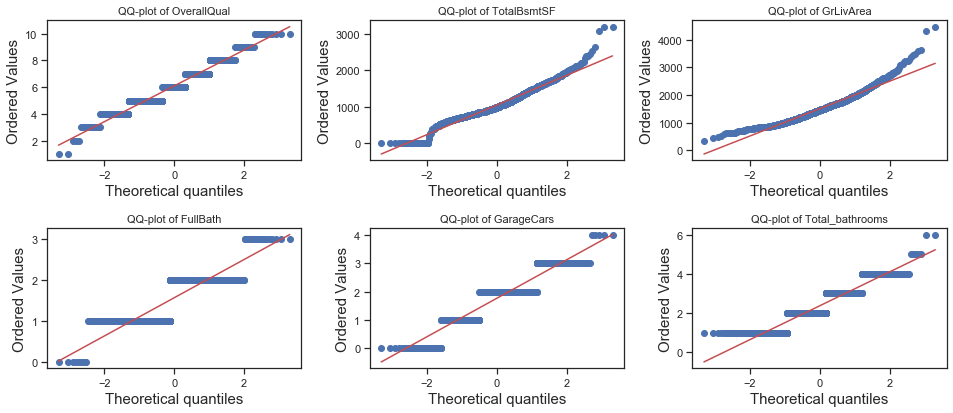

In [64]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4.5,nrows*3))
axes_list = [item for sublist in axes for item in sublist]
for col in t:
    ax = axes_list.pop(0) # Take the first axes of the axes_list
    probplot(X_train[col], dist = 'norm', plot = ax)
    str_title = "QQ-plot of {}".format(col)
    ax.set_title(str_title,fontsize=11)

    
plt.tight_layout(); 
plt.show();

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()

Converting other numerical columns to normal

In [65]:
for col in t:
    X_train[col] = boxcox1p(X_train[col], boxcox_normmax(X_train[col]+1))
    data[col] = boxcox1p(data[col], boxcox_normmax(data[col]+1))

Checking the normality of the columns again

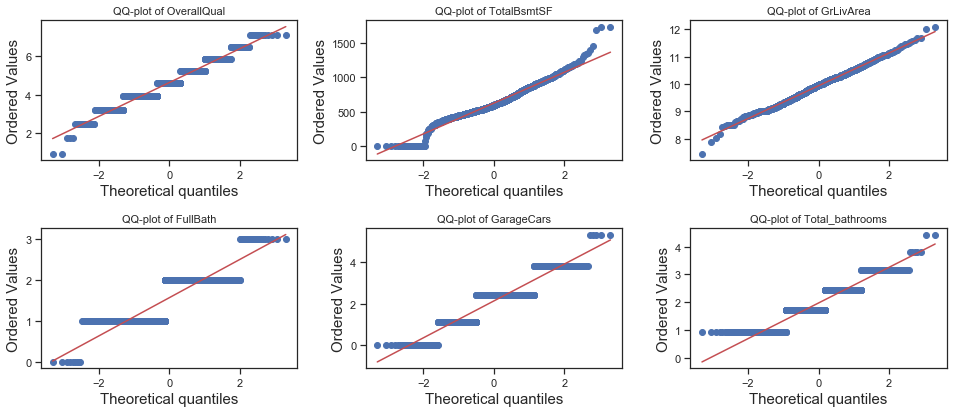

In [66]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4.5,nrows*3))
axes_list = [item for sublist in axes for item in sublist]
for col in t:
    ax = axes_list.pop(0) # Take the first axes of the axes_list
    probplot(X_train[col], dist = 'norm', plot = ax)
    str_title = "QQ-plot of {}".format(col)
    ax.set_title(str_title,fontsize=11)

    
plt.tight_layout(); 
plt.show();

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()

#### Nominal columns

In [67]:
nominal_cols = X_train.select_dtypes('object').columns.to_list()
nominal_cols

['LotConfig',
 'Neighborhood',
 'HouseStyle',
 'RoofStyle',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'HeatingQC',
 'SaleCondition']

## Modelling

In [68]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, OneHotEncoder,OrdinalEncoder, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV, SelectKBest

In [69]:
data.shape

(2916, 24)

In [70]:
X_train.shape

(1457, 25)

In [71]:
train = data.iloc[:len(X_train),:].copy()
train['SalePrice'] = X_train['SalePrice'].copy()
test = data.iloc[len(X_train):,:].copy()

In [72]:
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

Train shape:  (1457, 25)
Test shape:  (1459, 24)


In [73]:
X = train.loc[:,train.columns!='SalePrice']
y = train['SalePrice'].copy()
X.shape

(1457, 24)

In [74]:
X.head()

,LotShape,LandContour,LotConfig,Neighborhood,HouseStyle,OverallQual,RoofStyle,Exterior2nd,MasVnrType,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,TotalBsmtSF,HeatingQC,GrLivArea,FullBath,FireplaceQu,GarageType,GarageFinish,GarageCars,SaleCondition,Total_bathrooms
0,Reg,Lvl,Inside,CollgCr,2Story,5.391961,Gable,VinylSd,BrkFace,Gd,PConc,Gd,No,GLQ,418.285563,Ex,8.339937,1.810499,None,Attchd,RFn,2.241648,Normal,2.574343
1,Reg,Lvl,FR2,Veenker,1Story,4.715004,Gable,MetalSd,None,TA,CBlock,Gd,Gd,ALQ,587.580029,Ex,7.962252,1.810499,TA,Attchd,RFn,2.241648,Normal,1.503570
2,IR1,Lvl,Inside,CollgCr,2Story,5.391961,Gable,VinylSd,BrkFace,Gd,PConc,Gd,Mn,GLQ,445.546037,Ex,8.394286,1.810499,TA,Attchd,RFn,2.241648,Normal,2.574343
3,IR1,Lvl,Corner,Crawfor,2Story,5.391961,Gable,Wd Shng,None,TA,BrkTil,TA,No,ALQ,375.167203,Gd,8.345040,0.942176,Gd,Detchd,Unf,3.484370,Abnorml,1.503570
4,IR1,Lvl,FR2,NoRidge,2Story,6.052677,Gable,VinylSd,BrkFace,Gd,PConc,Gd,Av,GLQ,539.609942,Ex,8.654708,1.810499,TA,Attchd,RFn,3.484370,Normal,2.574343


In [75]:
train.shape

(1457, 25)

#### one hot encoder

In [76]:
ohe_dict_cols = {}
for col in X.select_dtypes(include=['object']).dtypes.index:
    ohe_dict_cols[col] = pd.Series(X[col].unique()).to_list()
    
# For one-hot encoder
t_k = []  # nominal column names
t_v = []  # values of nominal columns
for k,v in ohe_dict_cols.items():
    t_k.append(k)
    t_v.append(v)

#### Ordinal Encoder

In [77]:
ord_encod_dict = {}
for col in X.select_dtypes(include='category').columns:
    ord_encod_dict[col] = pd.Series(data[col].unique().sort_values()).to_list()

# For ordinal encoder
ordinal_cols = []
ordinal_vals = []
for k,v in ord_encod_dict.items():
    ordinal_cols.append(k)
    ordinal_vals.append(v)

In [78]:
number_cols = X.select_dtypes('number').columns.tolist()

In [79]:
number_cols

['OverallQual',
 'TotalBsmtSF',
 'GrLivArea',
 'FullBath',
 'GarageCars',
 'Total_bathrooms']

In [80]:
colT = ColumnTransformer([
    ('dummy_col', OneHotEncoder(drop = 'first', categories = t_v), t_k),
    ('norm', Normalizer(norm='l1'), number_cols),
    ('ordinal_cols', OrdinalEncoder(categories = ordinal_vals), ordinal_cols)
], remainder = 'drop')

[StratifiedKFold v.s KFold v.s StratifiedShuffleSplit](https://www.google.com/search?q=difference+between+kfold+and+stratified+kfold&rlz=1C1AVFC_enIN900IN900&oq=differe&aqs=chrome.1.69i57j35i39l2j0l5.2243j0j7&sourceid=chrome&ie=UTF-8)

In [81]:
def data_for_cv_or_modelling(cv = True, modelling = False, data= data, train = train, test = test):
    if cv:
        X = pd.get_dummies(train.loc[:,train.columns!='SalePrice'], drop_first = True, 
                           columns = ['LotConfig', 'Neighborhood', 'HouseStyle', 'RoofStyle', 'Exterior2nd',
       'MasVnrType', 'Foundation', 'HeatingQC', 'SaleCondition'])
        # category columns
        for col in X.select_dtypes('category').columns:
            X.loc[:,col] = X[col].cat.codes
        y = train['SalePrice'].copy()
    else:
        X = train.loc[:,train.columns!='SalePrice']
        y = train['SalePrice'].copy()
    return(X,y)


### Getting dummies for object columns

In [82]:
# Object columns
X = pd.get_dummies(X, drop_first = True, columns = ['LotConfig', 'Neighborhood', 'HouseStyle', 'RoofStyle', 'Exterior2nd',
       'MasVnrType', 'Foundation', 'HeatingQC', 'SaleCondition'])

In [83]:
# category columns
for col in X.select_dtypes('category').columns:
    X.loc[:,col] = X[col].cat.codes

In [84]:
X.head()

,LotShape,LandContour,OverallQual,ExterQual,BsmtQual,BsmtExposure,BsmtFinType1,TotalBsmtSF,GrLivArea,FullBath,FireplaceQu,GarageType,GarageFinish,GarageCars,Total_bathrooms,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,3,3,5.391961,3,4,1,6,418.285563,8.339937,1.810499,0,5,2,2.241648,2.574343,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1,3,3,4.715004,2,4,4,5,587.580029,7.962252,1.810499,3,5,2,2.241648,1.503570,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2,3,5.391961,3,4,2,6,445.546037,8.394286,1.810499,3,5,2,2.241648,2.574343,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,2,3,5.391961,2,3,1,5,375.167203,8.345040,0.942176,4,1,1,3.484370,1.503570,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,2,3,6.052677,3,4,3,6,539.609942,8.654708,1.810499,3,5,2,3.484370,2.574343,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [85]:
X.shape

(1457, 87)

In [86]:
# Setup cross validation folds
kf = KFold(n_splits = 12, random_state=1, shuffle=True)

## Light GBM

In [87]:
X.head()

,LotShape,LandContour,OverallQual,ExterQual,BsmtQual,BsmtExposure,BsmtFinType1,TotalBsmtSF,GrLivArea,FullBath,FireplaceQu,GarageType,GarageFinish,GarageCars,Total_bathrooms,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,3,3,5.391961,3,4,1,6,418.285563,8.339937,1.810499,0,5,2,2.241648,2.574343,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1,3,3,4.715004,2,4,4,5,587.580029,7.962252,1.810499,3,5,2,2.241648,1.503570,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2,3,5.391961,3,4,2,6,445.546037,8.394286,1.810499,3,5,2,2.241648,2.574343,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,2,3,5.391961,2,3,1,5,375.167203,8.345040,0.942176,4,1,1,3.484370,1.503570,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,2,3,6.052677,3,4,3,6,539.609942,8.654708,1.810499,3,5,2,3.484370,2.574343,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [88]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [89]:
def modelfit(model, X = X, y = y):
    accuracies = -cross_val_score(model, X, y, scoring="neg_root_mean_squared_error", cv = kf)
    print("RMSE for different folds: ")
    print(accuracies)
    print("RMSE mean: ", accuracies.mean())
    print("RMSE variance: ", accuracies.var())

1. Fix learning rate and number of estimators to default

In [91]:
lgbm = LGBMRegressor(boosting_type = 'gbdt' ,random_state=1, n_jobs=-1, learning_rate = 0.1)
lgbm.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [92]:
modelfit(lgbm)

RMSE for different folds: 
[0.15532721 0.1617664  0.12614779 0.1239103  0.14155856 0.13473564
 0.1415471  0.12733969 0.11623887 0.14393936 0.12526769 0.16319994]
RMSE mean:  0.13841487972507396
RMSE variance:  0.00022145984575428165


2. Tuning max_depth and min_child_weight.

In [93]:
lgbm = LGBMRegressor(boosting_type = 'gbdt' ,random_state=1, n_jobs=-1, learning_rate = 0.1)

pipeline = Pipeline(steps = [("lgbm", lgbm)])
param_grid = {"lgbm__max_depth": range(-1,10,2),
             "lgbm__min_child_weight": [1e-3, 1e-2, 0.1]}

lgbm_grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

lgbm_grid.fit(X, y)

print("Best gird parameters : ", lgbm_grid.best_params_)
print("RMSE: ", -lgbm_grid.best_score_)

Best gird parameters :  {'lgbm__max_depth': 3, 'lgbm__min_child_weight': 0.001}
RMSE:  0.13548403173497245


So improvement in lightGBM cv score. 

So taking the tuned parameter values and tune the gamma values.

In [96]:
lgbm = LGBMRegressor(boosting_type = 'gbdt' ,random_state=1, n_jobs=-1, learning_rate = 0.1, max_depth = 3, 
                     min_child_weight = 0.001)

pipeline = Pipeline(steps = [("lgbm", lgbm)])
param_grid = {"lgbm__min_split_gain ": [i/100.0 for i in range(0,5)]}

lgbm_grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

lgbm_grid.fit(X, y)

print("Best gird parameters : ", lgbm_grid.best_params_)
print("RMSE: ", -lgbm_grid.best_score_)

Best gird parameters :  {'lgbm__min_split_gain ': 0.0}
RMSE:  0.13548403173497245


So the best value for min_split_gain is 0. (default value)

Before proceeding, a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.

Setting up n_estimators using gridsearch

In [97]:
lgbm = LGBMRegressor(boosting_type = 'gbdt' ,random_state=1, n_jobs=-1, learning_rate = 0.1, max_depth = 3, 
                     min_child_weight = 0.001, min_split_gain = 0)

pipeline = Pipeline(steps = [("lgbm", lgbm)])
param_grid = {"lgbm__n_estimators": range(50, 1100, 50)}

lgbm_grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

lgbm_grid.fit(X, y)

print("Best gird parameters : ", lgbm_grid.best_params_)
print("RMSE: ", -lgbm_grid.best_score_)

Best gird parameters :  {'lgbm__n_estimators': 250}
RMSE:  0.13347525812743816


So best value of n_estimator is 250.

In [98]:
lgbm = LGBMRegressor(boosting_type = 'gbdt' ,random_state=1, n_jobs=-1, learning_rate = 0.1, max_depth = 3, 
                     min_child_weight = 0.001, min_split_gain = 0, n_estimators = 250)

pipeline = Pipeline(steps = [("lgbm", lgbm)])
param_grid = {"lgbm__reg_alpha": [1e-5, 1e-2, 0.1, 1, 100]}

lgbm_grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

lgbm_grid.fit(X, y)

print("Best gird parameters : ", lgbm_grid.best_params_)
print("RMSE: ", -lgbm_grid.best_score_)

Best gird parameters :  {'lgbm__reg_alpha': 0.01}
RMSE:  0.1325999961737999


best value for reg_alha is 0.01.

In [99]:
lgbm = LGBMRegressor(boosting_type = 'gbdt' ,random_state=1, n_jobs=-1, learning_rate = 0.1, max_depth = 3, 
                     min_child_weight = 0.001, min_split_gain = 0, n_estimators = 250, reg_alpha = 0.01)

pipeline = Pipeline(steps = [("lgbm", lgbm)])
param_grid = {"lgbm__learning_rate": [0.05, 0.02, 0.03, 0.1, 0.2, 0.3]}

lgbm_grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

lgbm_grid.fit(X, y)

print("Best gird parameters : ", lgbm_grid.best_params_)
print("RMSE: ", -lgbm_grid.best_score_)

Best gird parameters :  {'lgbm__learning_rate': 0.1}
RMSE:  0.1325999961737999


## 1. XGBoost Hyperparameter tuning

[HyperParameters for XGboost](https://www.datacamp.com/community/tutorials/xgboost-in-python#what)

#### Step 1: Fix learning rate and number of estimators for tuning tree-based parameters

In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

1. __max_depth = 5__ : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.
2. __min_child_weight = 1__ : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
3. __gamma = 0__ : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
4. __subsample, colsample_bytree = 0.8__ : This is a commonly used used start value. Typical values range between 0.5-0.9.


In [94]:
import xgboost as xgb

In [121]:
# Setup cross validation folds
kf = KFold(n_splits = 12, random_state=1, shuffle=True)

def modelfit(model, X = X, y = y):

    accuracies = -cross_val_score(model, X, y, scoring="neg_root_mean_squared_error", cv = kf)
    print("RMSE for different folds: ")
    print(accuracies)
    print("RMSE mean: ", accuracies.mean())
    print("RMSE variance: ", accuracies.var())
    
    plt.rcParams['figure.figsize'] = [11, 13];
    xgb.plot_importance(model);
#     plt.show()
    plt.ylabel('Feature Importance Score')
    plt.title('Feature Importances')
    

In [120]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=1, n_jobs = -1, max_depth = 5, min_child_weight = 1,
                         gamma = 0, subsample=0.8, colsample_bytree=0.8, learning_rate =0.1, n_estimators = 1000)

In [122]:
xg_reg.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

RMSE for different folds: 
[0.14070087 0.16115804 0.12872026 0.12213393 0.13386302 0.12676939
 0.13756515 0.11717174 0.10849879 0.13243383 0.11920671 0.16337724]
RMSE mean:  0.13263324769295118
RMSE variance:  0.0002509627804109131


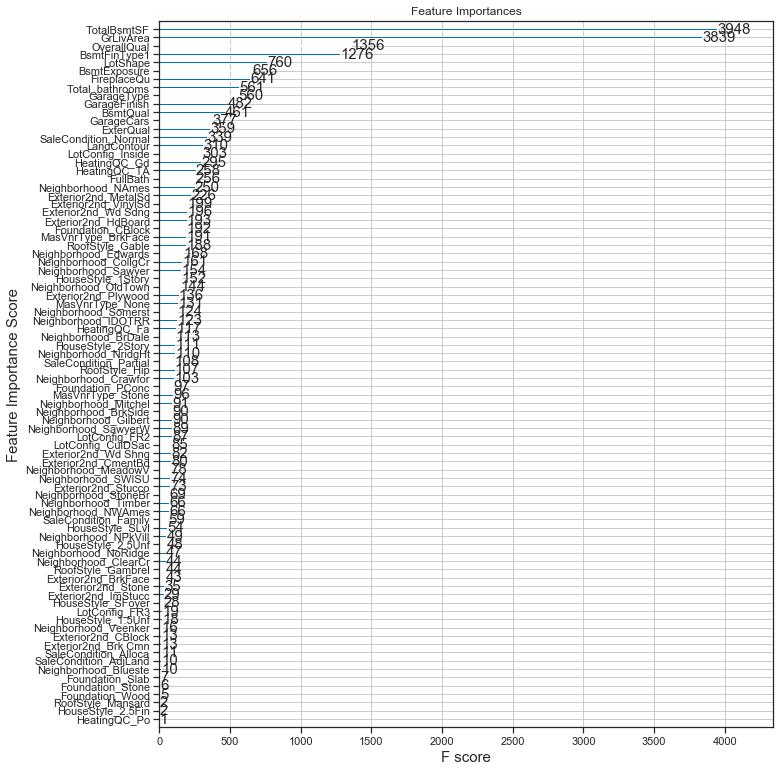

In [123]:
modelfit(model = xg_reg)

##### xgboost hyperparameter tuning  stp 2

In [124]:
pipeline = Pipeline(steps = [("xg", xg_reg)])
param_grid = {"xg__max_depth": range(3,10,2),
             "xg__min_child_weight": range(1,6,2)}

xgb_grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

xgb_grid.fit(X, y)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('xg',
                                        XGBRegressor(base_score=0.5,
                                                     booster='gbtree',
                                                     colsample_bylevel=1,
                                                     colsample_bynode=1,
                                                     colsample_bytree=0.8,
                                                     gamma=0,
                                                     importance_type='gain',
                                                     learning_rate=0.1,
                                                     max_delta_step=0,
                                                     max_depth=5,
                                                     min_child_weight=1,
                                                     missing=None,
                      

In [128]:
print("Best gird parameters : ", xgb_grid.best_params_)
print("RMSE: ", -xgb_grid.best_score_)

Best gird parameters :  {'xg__max_depth': 3, 'xg__min_child_weight': 5}
RMSE:  0.12964523404193037


So we set the __max_depth__ as 3.

To see if we increase min_child_weight from 5 to 6 or aobve lets see whether rmse decreases or not.

In [129]:
pipeline = Pipeline(steps = [("xg", xg_reg)])
param_grid = {"xg__min_child_weight": [6,7,8,9]}

xgb_grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

xgb_grid.fit(X, y)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('xg',
                                        XGBRegressor(base_score=0.5,
                                                     booster='gbtree',
                                                     colsample_bylevel=1,
                                                     colsample_bynode=1,
                                                     colsample_bytree=0.8,
                                                     gamma=0,
                                                     importance_type='gain',
                                                     learning_rate=0.1,
                                                     max_delta_step=0,
                                                     max_depth=5,
                                                     min_child_weight=1,
                                                     missing=None,
                      

In [131]:
print("Best gird parameters : ", xgb_grid.best_params_)
print("RMSE: ", -xgb_grid.best_score_)

Best gird parameters :  {'xg__min_child_weight': 7}
RMSE:  0.13196594615118745


So optimal value of max_depth: 3 and min_child_weight: 5.

#### Step 3: Tune gamma

In [132]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=1, n_jobs = -1, max_depth = 3, min_child_weight = 5,
                        gamma = 0, subsample=0.8, colsample_bytree=0.8, learning_rate =0.1, n_estimators = 1000)


pipeline = Pipeline(steps = [("xg", xg_reg)])
param_grid = {"xg__gamma": [i/10.0 for i in range(0,5)]}

xgb_grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

xgb_grid.fit(X, y)

print("Best gird parameters : ", xgb_grid.best_params_)
print("RMSE: ", -xgb_grid.best_score_)

Best gird parameters :  {'xg__gamma': 0.0}
RMSE:  0.12964523404193037


This shows that our original value of gamma, i.e. 0 is the optimum one. Before proceeding, a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.


Setting up n_estimators using gridsearch

In [134]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=1, n_jobs = -1, max_depth = 3, min_child_weight = 5,
                        gamma = 0, subsample=0.8, colsample_bytree=0.8, learning_rate =0.1, n_estimators = 1000)


pipeline = Pipeline(steps = [("xg", xg_reg)])
param_grid = {"xg__n_estimators": range(50, 1100, 50)}

xgb_grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

xgb_grid.fit(X, y)

print("Best gird parameters : ", xgb_grid.best_params_)
print("RMSE: ", -xgb_grid.best_score_)

Best gird parameters :  {'xg__n_estimators': 450}
RMSE:  0.1275607787423611


So the best value of n_estimators is 450.

So overall parameters tuned and their best values:
- max_depth = 3
- min_child_weight = 5
- n_estimators = 450
- gamma = 0


RMSE for different folds: 
[0.14019398 0.16035823 0.12353726 0.12118629 0.12534332 0.12392045
 0.1378234  0.1175421  0.10191056 0.12317295 0.11947627 0.15269649]
RMSE mean:  0.1289301090286594
RMSE variance:  0.00023898389483582115


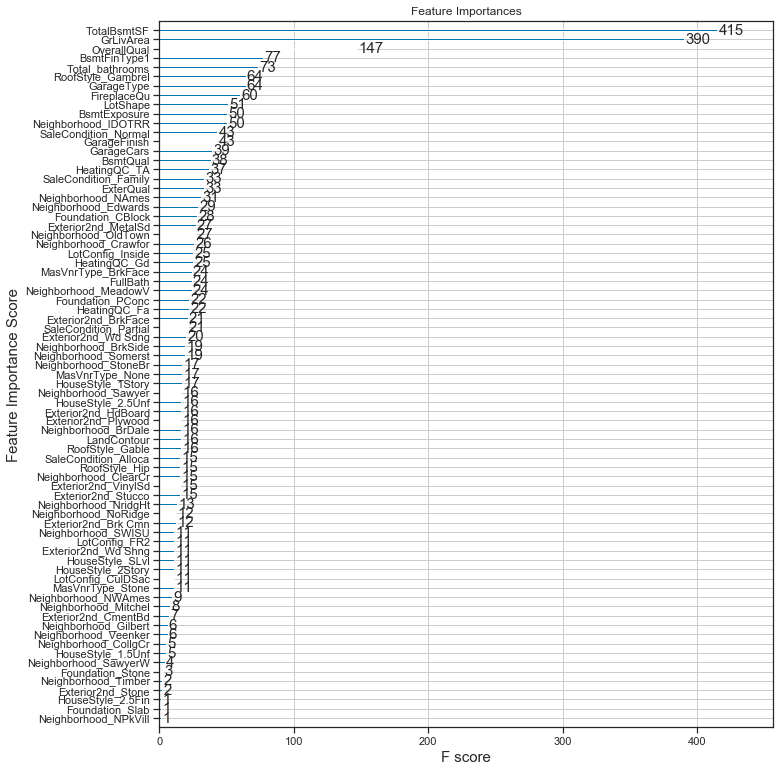

In [136]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=1, n_jobs = -1, max_depth = 3, min_child_weight = 5,
                         gamma = 0, subsample=0.8, colsample_bytree=0.8, learning_rate =0.1, n_estimators = 450)

xg_reg.fit(X,y)

modelfit(model = xg_reg)

So we can see improvement in score of RMSE.


#### Step 4: Tune subsample and colsample_bytree

The next step would be try different subsample and colsample_bytree values. Lets do this in 2 stages as well and take values 0.6,0.7,0.8,0.9 for both to start with.

In [137]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=1, n_jobs = -1, max_depth = 3, min_child_weight = 5,
                         gamma = 0, subsample=0.8, colsample_bytree=0.8, learning_rate =0.1, n_estimators = 450)


pipeline = Pipeline(steps = [("xg", xg_reg)])
param_grid = { 'xg__subsample':[i/10.0 for i in range(6,10)],
 'xg__colsample_bytree':[i/10.0 for i in range(6,10)]}

xgb_grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

xgb_grid.fit(X, y)

print("Best gird parameters : ", xgb_grid.best_params_)
print("RMSE: ", -xgb_grid.best_score_)

Best gird parameters :  {'xg__colsample_bytree': 0.7, 'xg__subsample': 0.8}
RMSE:  0.1273976545570087


Here, we found 0.8 and 0.7 as the optimum value for subsample and colsample_bytree respectively. Now we should try values in 0.05 interval around these.

In [138]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=1, n_jobs = -1, max_depth = 3, min_child_weight = 5,
                         gamma = 0, subsample=0.8, colsample_bytree=0.8, learning_rate =0.1, n_estimators = 450)


pipeline = Pipeline(steps = [("xg", xg_reg)])
param_grid = { 'xg__subsample':[i/100.0 for i in range(75, 90, 5)],
 'xg__colsample_bytree':[i/100.0 for i in range(75,90,5)]}

xgb_grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

xgb_grid.fit(X, y)

print("Best gird parameters : ", xgb_grid.best_params_)
print("RMSE: ", -xgb_grid.best_score_)

Best gird parameters :  {'xg__colsample_bytree': 0.8, 'xg__subsample': 0.8}
RMSE:  0.1275607787423611


So 0.8 and 0.7 are the optimum value for subsample and colsample_bytree respectively.

#### Step 5: Tuning Regularization Parameters

Next step is to apply regularization to reduce overfitting. Though many people don’t use this parameters much as gamma provides a substantial way of controlling complexity. But we should always try it. I’ll tune ‘reg_alpha’ value here and leave it upto you to try different values of ‘reg_lambda’.

In [139]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=1, n_jobs = -1, max_depth = 3, min_child_weight = 5,
                         gamma = 0, subsample=0.8, colsample_bytree=0.7, learning_rate =0.1, n_estimators = 450)


pipeline = Pipeline(steps = [("xg", xg_reg)])
param_grid = { 'xg__alpha':[1e-5, 1e-2, 0.1, 1, 100]}

xgb_grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

xgb_grid.fit(X, y)

print("Best gird parameters : ", xgb_grid.best_params_)
print("RMSE: ", -xgb_grid.best_score_)

Best gird parameters :  {'xg__alpha': 1e-05}
RMSE:  0.1273976545570087


So optimum value of alpha is 1e-5.

#### Step 6: Reducing Learning Rate

Lastly, we should lower the learning rate and add more trees. Lets use the cv function of XGBoost to do the job again.

In [141]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=1, n_jobs = -1, max_depth = 3, min_child_weight = 5,
                       alpha = 1e-5, gamma = 0, subsample=0.8, colsample_bytree=0.7, learning_rate =0.1, n_estimators = 450)


pipeline = Pipeline(steps = [("xg", xg_reg)])
param_grid = { 'xg__learning_rate':[0.05, 0.02, 0.03, 0.1, 0.2, 0.3],
             "xg__n_estimators": range(50, 1100, 50)}

xgb_grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

xgb_grid.fit(X, y)

print("Best gird parameters : ", xgb_grid.best_params_)
print("RMSE: ", -xgb_grid.best_score_)

Best gird parameters :  {'xg__learning_rate': 0.1, 'xg__n_estimators': 400}
RMSE:  0.1273887008155588


## Best XGBoost model

In [147]:
del(X,y)
X = train.loc[:,train.columns!='SalePrice']
y = train['SalePrice'].copy()

In [148]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=1, n_jobs = -1, max_depth = 3, min_child_weight = 5,
                       alpha = 1e-5, gamma = 0, subsample=0.8, colsample_bytree=0.7, learning_rate =0.1, n_estimators = 400)

colT = ColumnTransformer([
    ('dummy_col', OneHotEncoder(drop = 'first', categories = t_v), t_k),
    ('ordinal_cols', OrdinalEncoder(categories = ordinal_vals), ordinal_cols)
], remainder = 'drop')


pipeline = Pipeline(steps = [('colt', colT), ("xg", xg_reg)])
pipeline.fit(X, y)
prediction_XG_1 = pipeline.predict(test)

## 2. Random Forest Regressor hyperparameter tuning

In [151]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor(random_state=1, n_jobs = -1)

In [156]:
X, y = data_for_cv_or_modelling()

In [161]:
pipeline = Pipeline(steps = [("rf", rfreg)])
param_grid = {"rf__n_estimators": [50, 70, 100, 120, 140, 150], # number of trees in the forest.
             "rf__max_depth": [3,5, 6, 7,8],
             "rf__min_samples_leaf": [2, 3,4,5,6],
             "rf__max_samples":[None, 0.1, 0.2, 0.3]}

rf_grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')
rf_grid.fit(X,y)

print("Best gird parameters : ", rf_grid.best_params_)
print("RMSE: ", -rf_grid.best_score_)

Best gird parameters :  {'rf__max_depth': 8, 'rf__max_samples': None, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 120}
RMSE:  0.14539160538748028


### 5. Ridge regression

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's Robustscaler() method on pipeline

In [89]:
X,y = data_for_cv_or_modelling(cv = False, modelling = True)


from sklearn.linear_model import Ridge
ridge_reg = Ridge(random_state = 1)

rb_scaler = RobustScaler(with_centering=False)

colT = ColumnTransformer([
    ('dummy_col', OneHotEncoder(drop = 'first', categories = t_v), t_k),
    ('ordinal_cols', OrdinalEncoder(categories = ordinal_vals), ordinal_cols)
], remainder = 'passthrough')

# skb = SelectKBest(f_regression)

pipeline = Pipeline(steps = [('colt', colT), ('rb', rb_scaler), ("ridge", ridge_reg)])
param_grid = {
#     "SKB__k":[65,70,75,80,85,90], 
              "ridge__alpha": [20, 25, 30, 35, 40, 50, 75, 100],
             "ridge__fit_intercept": [True, False],
             "ridge__solver": ['auto', 'svd']}

grid = RandomizedSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_ridge = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE Ridge: ", -grid.best_score_)

training time: 4.991s
testing time: 0.016s
Best gird parameters :  {'ridge__solver': 'auto', 'ridge__fit_intercept': True, 'ridge__alpha': 25}
RMSE Ridge:  0.13424948937743308


### 6. Lasso Regression

In [90]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(random_state = 1)

rb_scaler = RobustScaler(with_centering=False)

colT = ColumnTransformer([
    ('dummy_col', OneHotEncoder(drop = 'first', categories = t_v), t_k),
    ('ordinal_cols', OrdinalEncoder(categories = ordinal_vals), ordinal_cols)
], remainder = 'passthrough')

# skb = SelectKBest(f_regression)

# Bigger the alpha values the lesser the features that will be selected

pipeline = Pipeline(steps = [('colt', colT),  ('rb', rb_scaler), ("lasso", lasso_reg)])
param_grid = {
#     "SKB__k":[65,70,75,80,85,90],
              "lasso__alpha": [0.0005,0.05,0.25,0.5,1,1.5,2],
             "lasso__fit_intercept": [True, False]}

grid = RandomizedSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_lassso = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE Lasso: ", -grid.best_score_)

training time: 7.348s
testing time: 0.031s
Best gird parameters :  {'lasso__fit_intercept': True, 'lasso__alpha': 0.0005}
RMSE Lasso:  0.13279508788331335


### 7. Elastic net regression

In [92]:
from sklearn.linear_model import ElasticNet
elastic_reg = ElasticNet(random_state = 1)

rb_scaler = RobustScaler(with_centering=False)

colT = ColumnTransformer([
    ('dummy_col', OneHotEncoder(drop = 'first', categories = t_v), t_k),
    ('ordinal_cols', OrdinalEncoder(categories = ordinal_vals), ordinal_cols)
], remainder = 'passthrough')

# skb = SelectKBest(f_regression)

# Bigger the alpha values the lesser the features that will be selected

pipeline = Pipeline(steps = [('colt', colT),  ('rb', rb_scaler), ("elastic", elastic_reg)])
param_grid = {
              "elastic__alpha": [0.0005,0.00025,0.05,0.25,0.5,1,1.5,2],
             "elastic__fit_intercept": [True, False],
             "elastic__l1_ratio":[.025,0.05, 0.07,0.08, 0.095]}

grid = RandomizedSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_elastic = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE Elastic net regression: ", -grid.best_score_)

training time: 10.162s
testing time: 0.016s
Best gird parameters :  {'elastic__l1_ratio': 0.095, 'elastic__fit_intercept': True, 'elastic__alpha': 0.0005}
RMSE Elastic net regression:  0.13403489758773687


## 8. SVR

In [115]:
from sklearn.svm import SVR
svr = SVR()

colT = ColumnTransformer([
    ('dummy_col',OneHotEncoder(drop = 'first',categories = t_v), t_k),
    ('ordinal_cols', OrdinalEncoder(categories = ordinal_vals), ordinal_cols)
], remainder = 'passthrough')


# skb = SelectKBest(f_regression)

pipeline = Pipeline(steps = [('colt', colT), ("svrpara", svr)])
param_grid = {
              "svrpara__kernel": ['rbf', 'linear', 'poly', 'sigmoid'],
             "svrpara__degree": [2,3,4],
             "svrpara__gamma": ['scale', 'auto'],
             "svrpara__C":[0.5,0.8,1],
             "svrpara__epsilon":[0.08,0.1,0.15,0.2]}

grid = RandomizedSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_svr = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE SVR: ", -grid.best_score_)

training time: 19.214s
testing time: 0.104s
Best gird parameters :  {'svrpara__kernel': 'rbf', 'svrpara__gamma': 'auto', 'svrpara__epsilon': 0.15, 'svrpara__degree': 3, 'svrpara__C': 1, 'SKB__k': 65}
RMSE SVR:  0.19127007763521559


In [116]:
X_train.dtypes

LotShape           category
LandContour        category
LotConfig            object
Neighborhood         object
HouseStyle           object
OverallQual         float64
RoofStyle            object
Exterior2nd          object
MasVnrType           object
ExterQual          category
Foundation           object
BsmtQual           category
BsmtExposure       category
BsmtFinType1       category
TotalBsmtSF         float64
HeatingQC            object
GrLivArea           float64
FullBath            float64
FireplaceQu        category
GarageType         category
GarageFinish       category
GarageCars          float64
SaleCondition        object
Total_bathrooms     float64
SalePrice           float64
dtype: object

### 9. Catboost

In [117]:
from catboost import CatBoostRegressor

In [118]:
cat_obj_cols = X.select_dtypes(['category', 'object']).columns.to_list()

In [119]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.7, random_state=1)

In [120]:
cat = CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, eval_metric = 'RMSE', loss_function='RMSE')

In [121]:
t0 = time()
cat.fit(X_train, y_train, cat_features = cat_obj_cols, eval_set= (X_validation, y_validation), plot=True);
print("training time: {}s".format(round(time()-t0, 3)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3686814	test: 0.3956823	best: 0.3956823 (0)	total: 220ms	remaining: 10.8s
1:	learn: 0.3486449	test: 0.3753184	best: 0.3753184 (1)	total: 233ms	remaining: 5.59s
2:	learn: 0.3297670	test: 0.3558703	best: 0.3558703 (2)	total: 241ms	remaining: 3.77s
3:	learn: 0.3133894	test: 0.3390126	best: 0.3390126 (3)	total: 259ms	remaining: 2.98s
4:	learn: 0.2990780	test: 0.3238691	best: 0.3238691 (4)	total: 264ms	remaining: 2.37s
5:	learn: 0.2846605	test: 0.3091692	best: 0.3091692 (5)	total: 269ms	remaining: 1.97s
6:	learn: 0.2720532	test: 0.2959699	best: 0.2959699 (6)	total: 273ms	remaining: 1.68s
7:	learn: 0.2610637	test: 0.2851086	best: 0.2851086 (7)	total: 283ms	remaining: 1.49s
8:	learn: 0.2502148	test: 0.2729601	best: 0.2729601 (8)	total: 294ms	remaining: 1.34s
9:	learn: 0.2408731	test: 0.2633501	best: 0.2633501 (9)	total: 298ms	remaining: 1.19s
10:	learn: 0.2323978	test: 0.2543419	best: 0.2543419 (10)	total: 301ms	remaining: 1.07s
11:	learn: 0.2248318	test: 0.2468400	best: 0.2468400

In [122]:
# test = data.iloc[len(X_train):,:].copy()
# best algorithm
# reg = grid.best_estimator_

t0 = time()
prediction_svr = cat.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
# print("Best gird parameters : ", grid.best_params_)
# print("RMSE SVR: ", -pipeline.best_score_)

testing time: 0.368s


## Catboost with grid

[Reference article](https://medium.com/@nilimeshhalder/how-to-find-optimal-parameters-for-catboost-using-gridsearchcv-for-regression-in-python-ef778b60d95d)

In [143]:
cat = CatBoostRegressor(cat_features = cat_obj_cols, loss_function='RMSE')

pipeline = Pipeline(steps = [("cat", cat)])
param_grid = {"cat__iterations": [30, 50, 70, 100],
             "cat__depth": [2,3,4,5,6],
             "cat__learning_rate": [0.01, 0.025, 0.05, 0.1],
             'cat__l2_leaf_reg': [1, 3, 5, 7, 9]}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error', n_jobs = -1)



In [146]:
t0 = time()
grid.fit(X, y);


print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_cat_grid = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE SVR: ", -grid.best_score_)

0:	learn: 0.3707352	total: 35.1ms	remaining: 3.48s
1:	learn: 0.3459948	total: 79.7ms	remaining: 3.9s
2:	learn: 0.3251247	total: 141ms	remaining: 4.56s
3:	learn: 0.3047871	total: 185ms	remaining: 4.44s
4:	learn: 0.2862508	total: 234ms	remaining: 4.45s
5:	learn: 0.2715835	total: 260ms	remaining: 4.08s
6:	learn: 0.2579988	total: 283ms	remaining: 3.76s
7:	learn: 0.2460441	total: 298ms	remaining: 3.43s
8:	learn: 0.2347100	total: 322ms	remaining: 3.25s
9:	learn: 0.2251592	total: 362ms	remaining: 3.25s
10:	learn: 0.2158554	total: 391ms	remaining: 3.16s
11:	learn: 0.2078207	total: 422ms	remaining: 3.09s
12:	learn: 0.2005352	total: 442ms	remaining: 2.96s
13:	learn: 0.1937013	total: 464ms	remaining: 2.85s
14:	learn: 0.1876292	total: 503ms	remaining: 2.85s
15:	learn: 0.1821929	total: 550ms	remaining: 2.89s
16:	learn: 0.1771871	total: 596ms	remaining: 2.91s
17:	learn: 0.1729452	total: 642ms	remaining: 2.92s
18:	learn: 0.1694315	total: 666ms	remaining: 2.84s
19:	learn: 0.1657720	total: 716ms	remain

### Submission

In [147]:
test = pd.read_csv('test.csv')

To get our original SalePrice values back, we will apply `np.expm1` at the end of the study to cancel the `log1p` transformation after training and testing the models.

In [148]:
sub_pred = np.expm1(prediction_cat_grid)

In [149]:
df_output = pd.DataFrame()
df_output['Id'] = test['Id']
df_output['SalePrice'] = sub_pred
df_output.head()

,Id,SalePrice
0,1461,116401.453986
1,1462,147953.365405
2,1463,174783.165836
3,1464,185733.359979
4,1465,201842.448161


In [150]:
df_output.to_csv('submission_7.csv', index = False)

In [ ]:
# progress = pd.DataFrame()
# progress['date'] = pd.to_datetime(['2020-05-13', '2020-05-25', '2020-05-31', '2020-06-06', '2020-06-12'])
# progress['rmse'] = [0.1501, 0.1541, 0.1365, 0.1358,0.134]
# progress

In [ ]:
# sns.lineplot(data = progress, x = 'date', y = 'rmse');
# plt.title('Variation in RMSE of models created');
# plt.xticks(rotation=90);